# Mars: solar occultation measurement

In this example, we show how archNEMESIS can be used to calculate forward models for solar occultation. In particular, we are going to model the spectral signatures of different isotopes of CO (i.e., $^{12}$C$^{16}$O, $^{13}$C$^{16}$O and $^{12}$C$^{18}$O) in the atmosphere of Mars between 4170-4190 cm$^{-1}$ as observed by a high-resolution spectrometer (i.e., FWHM = 0.16 cm$^{-1}$).

First of all, we show how all the input files can be read at once, and summarise the content of these files. Then, we will show how the forward models can be easily computed in python.

In [1]:
import archnemesis as ans
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

## 1. Input files

archNEMESIS includes the *read_input_files()* function, which automatically reads all NEMESIS input files (in the standard format) and stores the information in the reference classes. Here, we explore some of the most important characteristics of this particular forward model.

In [2]:
runname = 'mars_SO'

#Reading the input files
Atmosphere,Measurement,Spectroscopy,Scatter,Stellar,Surface,CIA,Layer,Variables,Retrieval = ans.Files.read_input_files(runname)

### Atmosphere

The profiles in this example were extracted from the Mars Climate Database v5.3 (Forget et al., 1999) using the climatological scenario, calculated at a latitude and longitude of 20$^\circ$N and 0$^\circ$E, at a local time of 8h (AM) and a solar longitude of 270$^\circ$ (i.e., summer solstice in the southern hemisphere).

The abundance of CO predicted by the model was split into three different isotopes using the same isotopic fractionation as on Earth (i.e., $^{12}$C$^{16}$O = 98.65%; $^{13}$C$^{16}$O = 1.11%; $^{12}$C$^{18}$O = 0.19%).

We do not include any aerosol profiles in the atmosphere for this particular example.

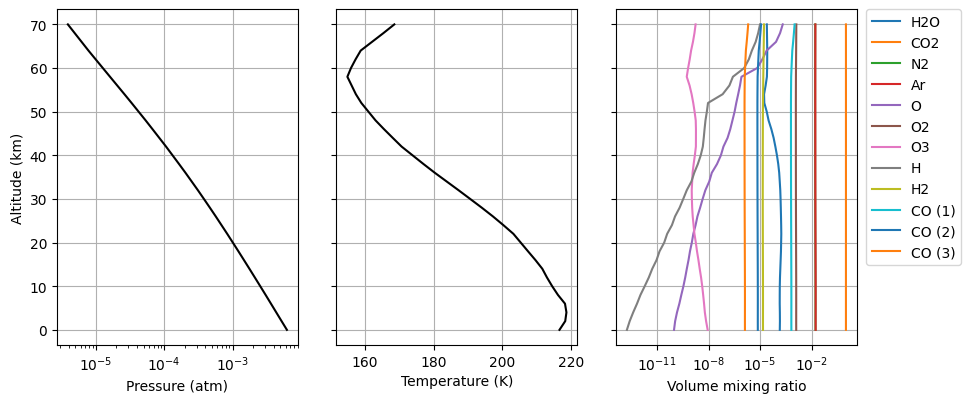

In [3]:
Atmosphere.plot_Atm()

### Measurement

In this example, as we only want to model the spectrum, the information about the measured spectra is not relevant. However, the *.spx* file also defines the geometry of the observations and the spectral range and resolution to use.

The spectral range in this example goes from 4170-4190 cm$^{-1}$, using a Gaussian instrument function with a FWHM of 0.16 cm$^{-1}$. The spectra is modelled at different tangent heights, ranging from 0-28 km with a vertical sampling of 2 km.

In [4]:
Measurement.summary_info()

Spectral resolution of the measurement (FWHM) ::  0.16
Field-of-view centered at ::  Latitude 20.0 - Longitude 0.0
There are  15 geometries in the measurement vector

GEOMETRY 1
Minimum wavelength/wavenumber ::  4170.0  - Maximum wavelength/wavenumber ::  4190.0
Limb-viewing or solar occultation measurement. Latitude ::  20.0  - Longitude ::  0.0  - Tangent height ::  0.0

GEOMETRY 2
Minimum wavelength/wavenumber ::  4170.0  - Maximum wavelength/wavenumber ::  4190.0
Limb-viewing or solar occultation measurement. Latitude ::  20.0  - Longitude ::  0.0  - Tangent height ::  2.0

GEOMETRY 3
Minimum wavelength/wavenumber ::  4170.0  - Maximum wavelength/wavenumber ::  4190.0
Limb-viewing or solar occultation measurement. Latitude ::  20.0  - Longitude ::  0.0  - Tangent height ::  4.0

GEOMETRY 4
Minimum wavelength/wavenumber ::  4170.0  - Maximum wavelength/wavenumber ::  4190.0
Limb-viewing or solar occultation measurement. Latitude ::  20.0  - Longitude ::  0.0  - Tangent height ::  6.

### Variables

In this example, we choose a parameterisation that allows us to easily change the isotopic ratios in the atmosphere. In particular, we choose the model parameterisation #2, which allows the scaling of an atmospheric profile and apply it to the minor isotopologues of CO, so that the scaling factors represent the isotopic ratios with respect to the Earth-like fractionation.

In [5]:
print('VARIDENT')
print(Variables.VARIDENT)
print('')

print('Isotopic ratios with respect to Earth')
print(Variables.XA)
print('')

VARIDENT
[[5 2 2]
 [5 3 2]]

Isotopic ratios with respect to Earth
[0.9  0.95]



### CIA

Given the low pressure of the atmosphere of Mars, Collision-Induced Absorption (CIA) is not relevant and is therefore not required. archNEMESIS will look for the *.cia* file, and if it is not present, it will not use CIA for the radiative transfer calculations, leaving this reference class empty.

In [6]:
print(CIA)

None


### Spectroscopy

In this example, we do not include the high-resolution tables in the current working directory because of storage requirements, although these are available upon request.

Here, we include only the three isotopologues of CO to contribute to the measured spectrum, as the absorption of all other gases in the atmosphere of Mars in this spectral range is negligible. 

In [7]:
Spectroscopy.summary_info()

Calculation type ILBL ::  2  (line-by-line)
Number of radiatively-active gaseous species ::  3
Gaseous species ::  ['CO (1)', 'CO (2)', 'CO (3)']
Number of spectral points ::  20577
Wavelength range ::  4169.712086431682 - 4190.28808740899
Step size ::  0.0010000000474974513
Number of temperature levels ::  20
Temperature range ::  30.0 - 300.0 K
Number of pressure levels ::  20
Pressure range ::  1.5229979e-08 - 0.13533528 atm


### Layering

In this case, we specify the base altitude of the layers based on the tangent heights of our spectra. The base altitudes are specified in the Layer class.

In [8]:
Layer.summary_info()

Number of layers ::  35
Layers calculated by specified base altitudes
Layer properties calculated through mass weighted averages


## 2. Running a foward model

After having read the input files and explored some of the most relevant parameters, we can easily perform a forward model.There are two main ways of doing this:

- Since all NEMESIS input files are present in the working directory, the forward model could be performed using the nemesisSO.py program from the command window. This is the main program for running a solar occultation retrieval, but if *NITER* = -1 in the *.inp* file, then a forward model is calculated, not a retrieval. After running the program, the forward model will be stored in the *.mre* file.

- The forward model can be calculated in python using the Forward Model class. In particular, we will use the *nemesisSOfm()*, which is specific and optimised for solar occultation measurements. This function will simultaneously compute the foward models at the different tangent heights, which is much faster than simulating each geometry (i.e., each tangent height) independently, as would be performed using *nemesisfm()*. After running this function, the forward model will be stored as an array.

Here, we use the second approach.

In [9]:
Atmosphere,Measurement,Spectroscopy,Scatter,Stellar,Surface,CIA,Layer,Variables,Retrieval = ans.Files.read_input_files(runname)
ForwardModel = ans.ForwardModel_0(runname=runname, Atmosphere=Atmosphere,Surface=Surface,Measurement=Measurement,Spectroscopy=Spectroscopy,Stellar=Stellar,Scatter=Scatter,CIA=CIA,Layer=Layer,Variables=Variables)

SPECONV = ForwardModel.nemesisSOfm()

CIRSrad :: CIA not included in calculations
CIRSrad :: Aerosol optical depths at  4169.712086431682  ::  [0.]
Convolving spectra and gradients with instrument line shape


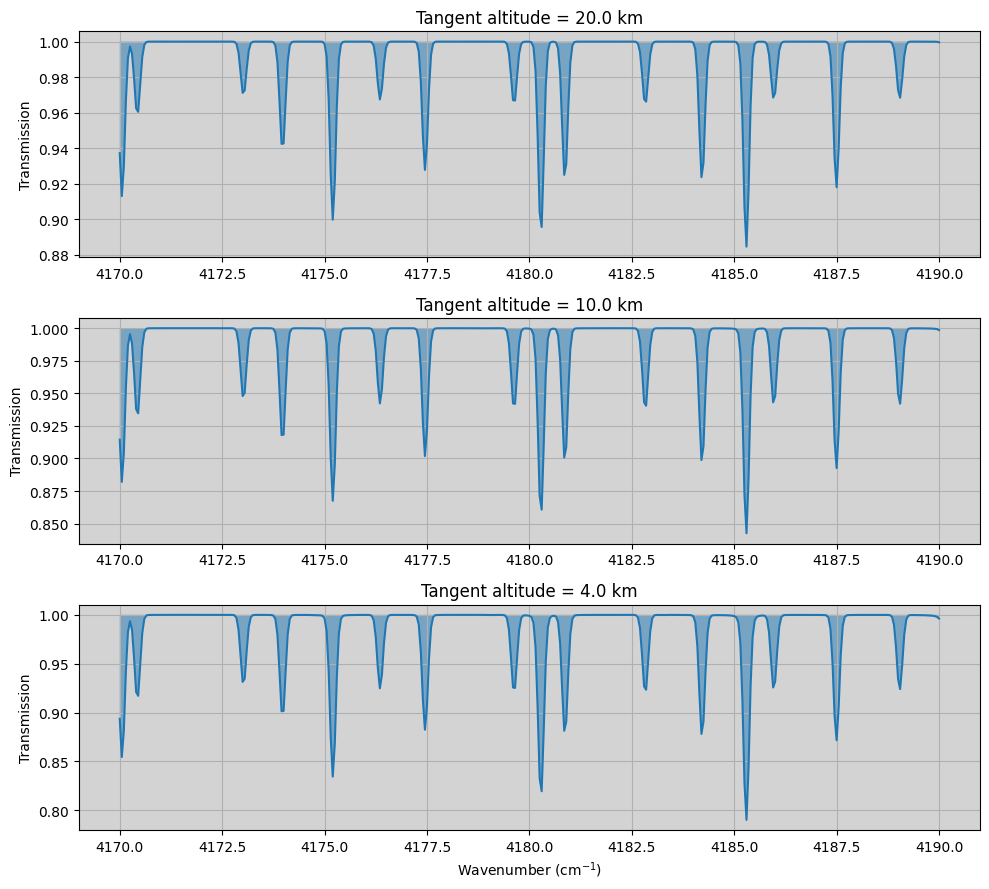

In [10]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,9))

#First geometry
igeom1 = Measurement.NGEOM-5
ax1.fill_between(Measurement.VCONV[:,igeom1],SPECONV[:,igeom1],np.ones(Measurement.NCONV[igeom1]),alpha=0.5)
ax1.plot(Measurement.VCONV[:,igeom1],SPECONV[:,igeom1])
ax1.set_facecolor('lightgray')
ax1.grid()
ax1.set_title('Tangent altitude = '+str(Measurement.TANHE[igeom1,0])+' km')
ax1.set_ylabel('Transmission')

#Second geometry
igeom2 = 5
ax2.fill_between(Measurement.VCONV[:,igeom2],SPECONV[:,igeom2],np.ones(Measurement.NCONV[igeom2]),alpha=0.5)
ax2.plot(Measurement.VCONV[:,igeom2],SPECONV[:,igeom2])
ax2.set_facecolor('lightgray')
ax2.grid()
ax2.set_title('Tangent altitude = '+str(Measurement.TANHE[igeom2,0])+' km')
ax2.set_ylabel('Transmission')


#Third geometry
igeom3 = 2
ax3.fill_between(Measurement.VCONV[:,igeom3],SPECONV[:,igeom3],np.ones(Measurement.NCONV[igeom3]),alpha=0.5)
ax3.plot(Measurement.VCONV[:,igeom3],SPECONV[:,igeom3])
ax3.set_facecolor('lightgray')
ax3.grid()
ax3.set_title('Tangent altitude = '+str(Measurement.TANHE[igeom3,0])+' km')
ax3.set_ylabel('Transmission')
ax3.set_xlabel('Wavenumber (cm$^{-1}$)')

plt.tight_layout()

## 3. Calculating the jacobian matrix

Similarly, apart from the forward model, archNEMESIS allows the calculation of the jacobian matrix, which includes information about the sensitivity of the spectrum to each of the parameters in the state vector. These calculations are also easily performed using the Forward Model class using the *jacobian_nemesis()* function. In particular, all the parameters included in the state vector for this particular example can be calculated analytically, although in some cases the derivatives have to be calculated numerically.

In this particular example, we turn the *nemesisSO* flag on, to run the optimised version of the forward model for solar occultations. The output of this function is the measurement vector (i.e., concatenation of all the transmission spectra at the different tangent heights), and the jacobian matrix (i.e., derivative of the transmission spectra with respect to the elements of the state vector, which represent the isotopic ratios). 

In [11]:
Atmosphere,Measurement,Spectroscopy,Scatter,Stellar,Surface,CIA,Layer,Variables,Retrieval = ans.Files.read_input_files(runname)
YN,KK = ForwardModel.jacobian_nemesis(nemesisSO=True)

Calculating analytical part of the Jacobian :: Calling nemesisfmg 
Running CIRSradg
CIRSrad :: CIA not included in calculations
CIRSradg :: Calculating DUST opacity
CIRSrad :: Aerosol optical depths at  4169.712086431682  ::  [0.]
CIRSradg :: Calculating GAS opacity
CIRSradg :: Calculating TOTAL opacity
CIRSradg :: Calculating TOTAL line-of-sight opacity
CIRSradg :: Calculating TRANSMISSION
CIRSradg :: Calculating GRADIENTS
CIRSradg :: Integrading over g-ordinates
Mapping gradients from Layer to Profile
Mapping gradients from Profile to State Vector
Convolving spectra and gradients with instrument line shape


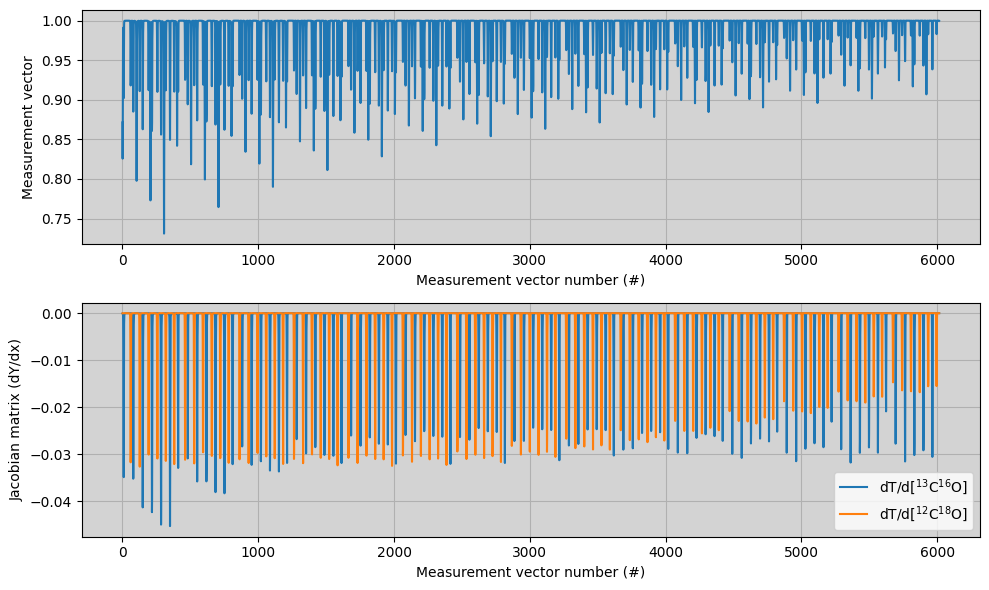

In [12]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,6))

ax1.plot(range(len(YN)),YN)
ax2.plot(range(len(YN)),KK[:,0],label='dT/d[$^{13}$C$^{16}$O]')
ax2.plot(range(len(YN)),KK[:,1],label='dT/d[$^{12}$C$^{18}$O]')
ax2.legend()

ax1.grid()
ax2.grid()
ax1.set_facecolor('lightgray')
ax2.set_facecolor('lightgray')

ax1.set_ylabel('Measurement vector')
ax1.set_xlabel('Measurement vector number (#)')

ax2.set_ylabel('Jacobian matrix (dY/dx)')
ax2.set_xlabel('Measurement vector number (#)')

plt.tight_layout()

## 4. Calculating the spectral signature of each gas

Similarly, we can change some of the parameters in our reference classes to calculate a modified version of the forward model. In this example, we specifically want to test what the spectral signature of each of the CO isotopologues is in the spectra. In order to test this, we need to run three different forward models only using one radiatively active gas at a time (i.e., one forward model for each isotpologue). 

In [13]:
#Getting the location of the lbl-tables
lbltables = Spectroscopy.LOCATION
nfm = len(lbltables)

#Running the forward model
ForwardModel = ans.ForwardModel_0(runname=runname, Atmosphere=Atmosphere,Surface=Surface,Measurement=Measurement,Spectroscopy=Spectroscopy,Stellar=Stellar,Scatter=Scatter,CIA=CIA,Layer=Layer,Variables=Variables)
SPECONV = ForwardModel.nemesisSOfm()

SPECONV_gas = np.zeros((Measurement.NCONV[0],Measurement.NGEOM,nfm))
for i in range(nfm):
    
    #Defining only one gas in the spectroscopy 
    Spectroscopy1 = copy(Spectroscopy)
    Spectroscopy1.NGAS = 1
    Spectroscopy1.LOCATION = [lbltables[i]]
    Spectroscopy1.ID = [Spectroscopy.ID[i]]
    Spectroscopy1.ISO = [Spectroscopy.ISO[i]]
    Spectroscopy1.read_tables(wavemin=Measurement.WAVE.min(),wavemax=Measurement.WAVE.max())

    #Running the forward model
    ForwardModel = ans.ForwardModel_0(runname=runname, Atmosphere=Atmosphere,Surface=Surface,Measurement=Measurement,Spectroscopy=Spectroscopy1,Stellar=Stellar,Scatter=Scatter,CIA=CIA,Layer=Layer,Variables=Variables)
    SPECONV1 = ForwardModel.nemesisSOfm()
    
    #Saving the results
    SPECONV_gas[:,:,i] = SPECONV1[:,:]
    

CIRSrad :: CIA not included in calculations
CIRSrad :: Aerosol optical depths at  4169.712086431682  ::  [0.]
Convolving spectra and gradients with instrument line shape
CIRSrad :: CIA not included in calculations
CIRSrad :: Aerosol optical depths at  4169.712086431682  ::  [0.]
Convolving spectra and gradients with instrument line shape
CIRSrad :: CIA not included in calculations
CIRSrad :: Aerosol optical depths at  4169.712086431682  ::  [0.]
Convolving spectra and gradients with instrument line shape
CIRSrad :: CIA not included in calculations
CIRSrad :: Aerosol optical depths at  4169.712086431682  ::  [0.]
Convolving spectra and gradients with instrument line shape


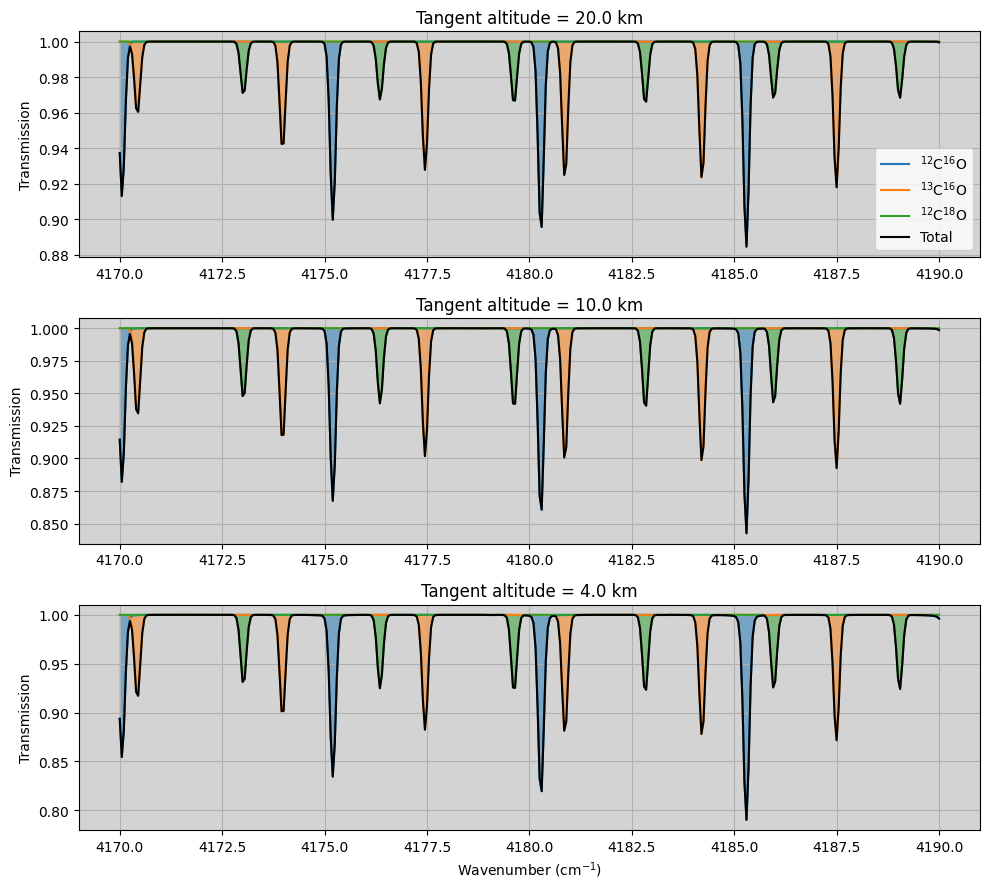

In [14]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,9))

igeom1 = Measurement.NGEOM-5
igeom2 = 5
igeom3 = 2

labels = ['$^{12}$C$^{16}$O','$^{13}$C$^{16}$O','$^{12}$C$^{18}$O']

for iso in range(nfm):

    ax1.fill_between(Measurement.VCONV[:,igeom1],SPECONV_gas[:,igeom1,iso],np.ones(Measurement.NCONV[igeom1]),alpha=0.5)
    ax1.plot(Measurement.VCONV[:,igeom1],SPECONV_gas[:,igeom1,iso],label=labels[iso])
    ax2.fill_between(Measurement.VCONV[:,igeom2],SPECONV_gas[:,igeom2,iso],np.ones(Measurement.NCONV[igeom1]),alpha=0.5)
    ax2.plot(Measurement.VCONV[:,igeom2],SPECONV_gas[:,igeom2,iso],label=labels[iso])
    ax3.fill_between(Measurement.VCONV[:,igeom3],SPECONV_gas[:,igeom3,iso],np.ones(Measurement.NCONV[igeom1]),alpha=0.5)
    ax3.plot(Measurement.VCONV[:,igeom3],SPECONV_gas[:,igeom3,iso],label=labels[iso])

offset= 0.0
ax1.plot(Measurement.VCONV[:,igeom1],SPECONV[:,igeom1]+offset,c='black',label='Total')
ax2.plot(Measurement.VCONV[:,igeom2],SPECONV[:,igeom2]+offset,c='black',label='Total')
ax3.plot(Measurement.VCONV[:,igeom3],SPECONV[:,igeom3]+offset,c='black',label='Total')

ax1.legend()
ax1.set_facecolor('lightgray')
ax2.set_facecolor('lightgray')
ax3.set_facecolor('lightgray')
ax1.set_title('Tangent altitude = '+str(Measurement.TANHE[igeom1,0])+' km')
ax2.set_title('Tangent altitude = '+str(Measurement.TANHE[igeom2,0])+' km')
ax3.set_title('Tangent altitude = '+str(Measurement.TANHE[igeom3,0])+' km')
ax1.set_ylabel('Transmission')
ax2.set_ylabel('Transmission')
ax3.set_ylabel('Transmission')
ax3.set_xlabel('Wavenumber (cm$^{-1}$)')
ax1.grid()
ax2.grid()
ax3.grid()
plt.tight_layout()